# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.23.4 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM neutrophil lineages

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T                        327
CD8 T                        171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
EI macrophage                 92
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
Immature B cell             1998
MEMP                          16
MEP                          269
MK                          1036
MPP lymphoid                  34
MPP myeloid 1                 46
MPP myeloid 2                 46
NKT                          137
Naive B cell                1423
Pre B progenitor           14234
Pre pro B progenitor        5428
Pro B progenitor            5530
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     13

In [6]:
myeloid_celltypes = ['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 'CMP', 'GMP', 'neut myeloid', 'promyelocyte', 'myelocyte', 'neutrophil']

In [7]:
adata = adata[adata.obs['cell.labels'].isin(myeloid_celltypes)].copy()

In [8]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].replace(['MPP myeloid 1', 'MPP myeloid 2'], ['MPP myeloid', 'MPP myeloid'])

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP              425
GMP             1285
HSC               92
MPP myeloid       92
myelocyte       3854
neut myeloid    4184
neutrophil      4516
promyelocyte    1922
dtype: int64

In [10]:
adata.shape

(16370, 33712)

# Pre-process the dataset

In [11]:
# normalise count data 
sc.pp.normalize_total(adata)

In [12]:
# log the count data 
sc.pp.log1p(adata)

In [13]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [14]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [15]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [16]:
# run pca
sc.tl.pca(adata, n_comps=50)

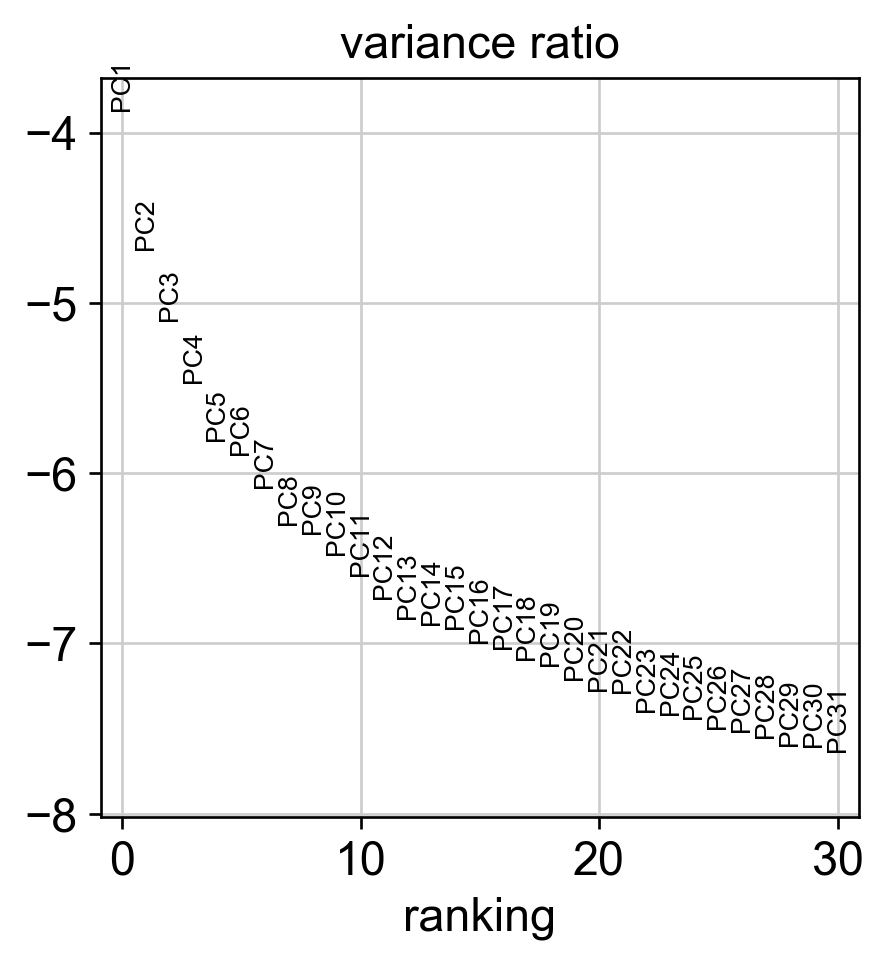

In [17]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [19]:
# run umap
sc.tl.umap(adata) 

... storing 'cell.labels' as categorical


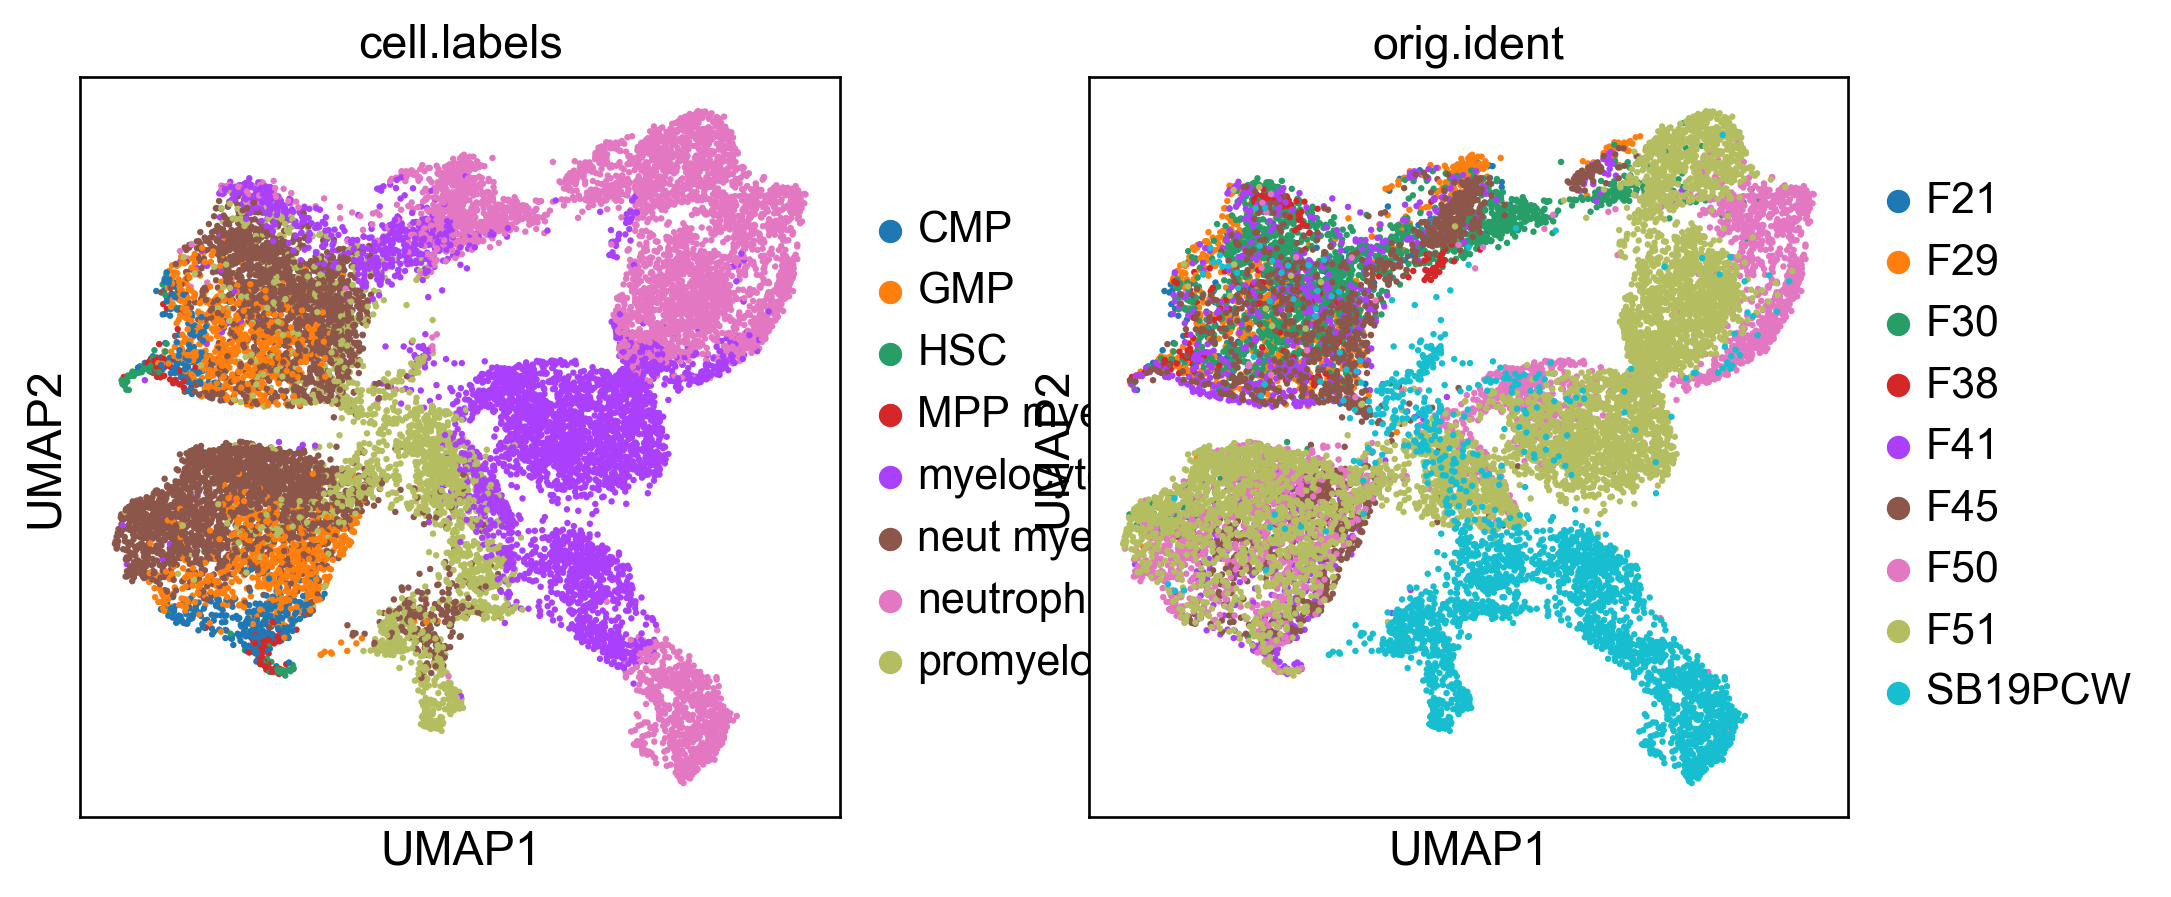

In [20]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [21]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [22]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [23]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [24]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

In [25]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [26]:
# run umap
sc.tl.umap(adata) 

In [27]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

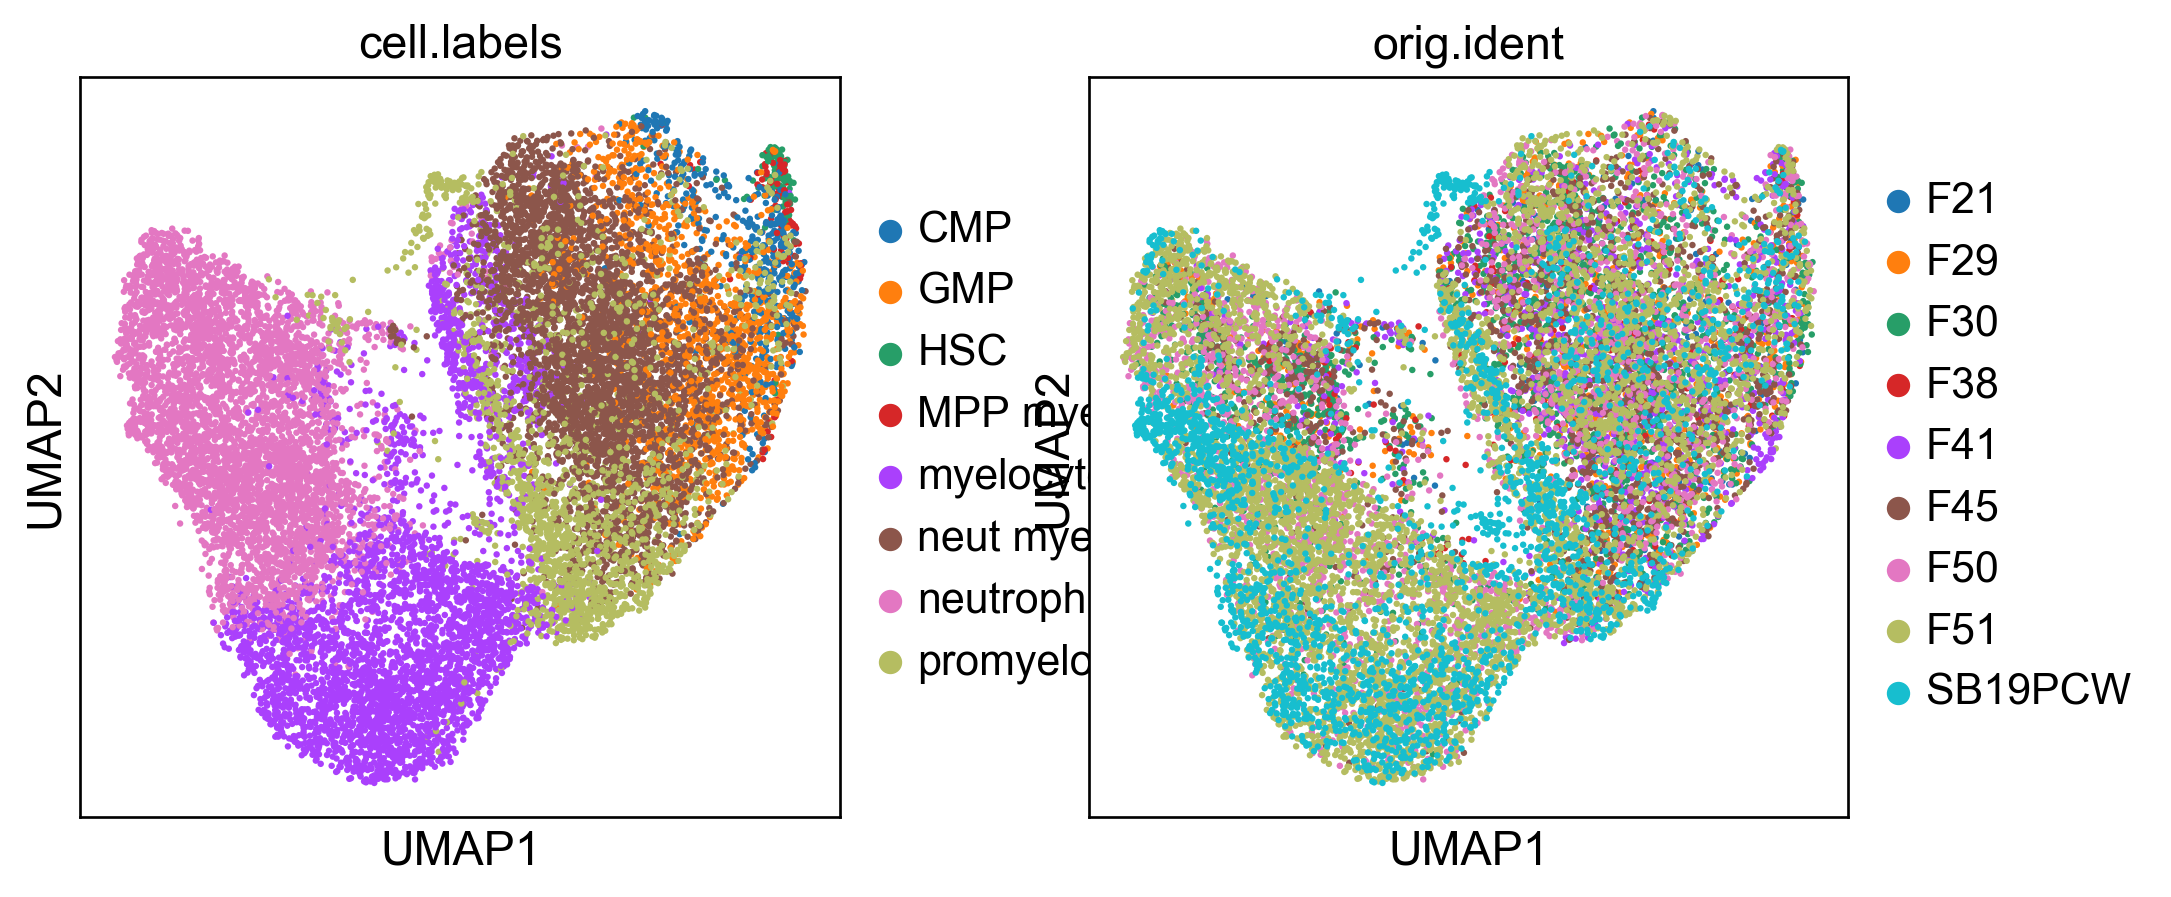

In [28]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Change the colours for the gran and neut lineage

In [29]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'GMP', 'HSC', 'MPP myeloid', 'myelocyte', 'neut myeloid',
       'neutrophil', 'promyelocyte'],
      dtype='object')

In [30]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'MPP myeloid',
                 'CMP', 'GMP', 'neut myeloid', 'promyelocyte', 'myelocyte', 'neutrophil'])

In [31]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'MPP myeloid', 'CMP', 'GMP', 'neut myeloid', 'promyelocyte',
       'myelocyte', 'neutrophil'],
      dtype='object')

In [32]:
adata.obs["cell.labels"].cat.categories[2]

'CMP'

In [33]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#d200d2' # HSC
new_colors[[1]] = '#0000ff' # MPP myeloid
new_colors[[2]] = '#a56900' # CMP
new_colors[[3]] = '#f79d00' # GMP
new_colors[[4]] = '#ffc055' # neut myeloid
new_colors[[5]] = '#ff254e' # promyelocyte
new_colors[[6]] = '#ff7790'# myelocyte
new_colors[[7]] = '#ffc7d2' # neutrophil

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#d200d2', '#0000ff', '#a56900', '#f79d00', '#ffc055', '#ff254e',
       '#ff7790', '#ffc7d2'], dtype='<U7')

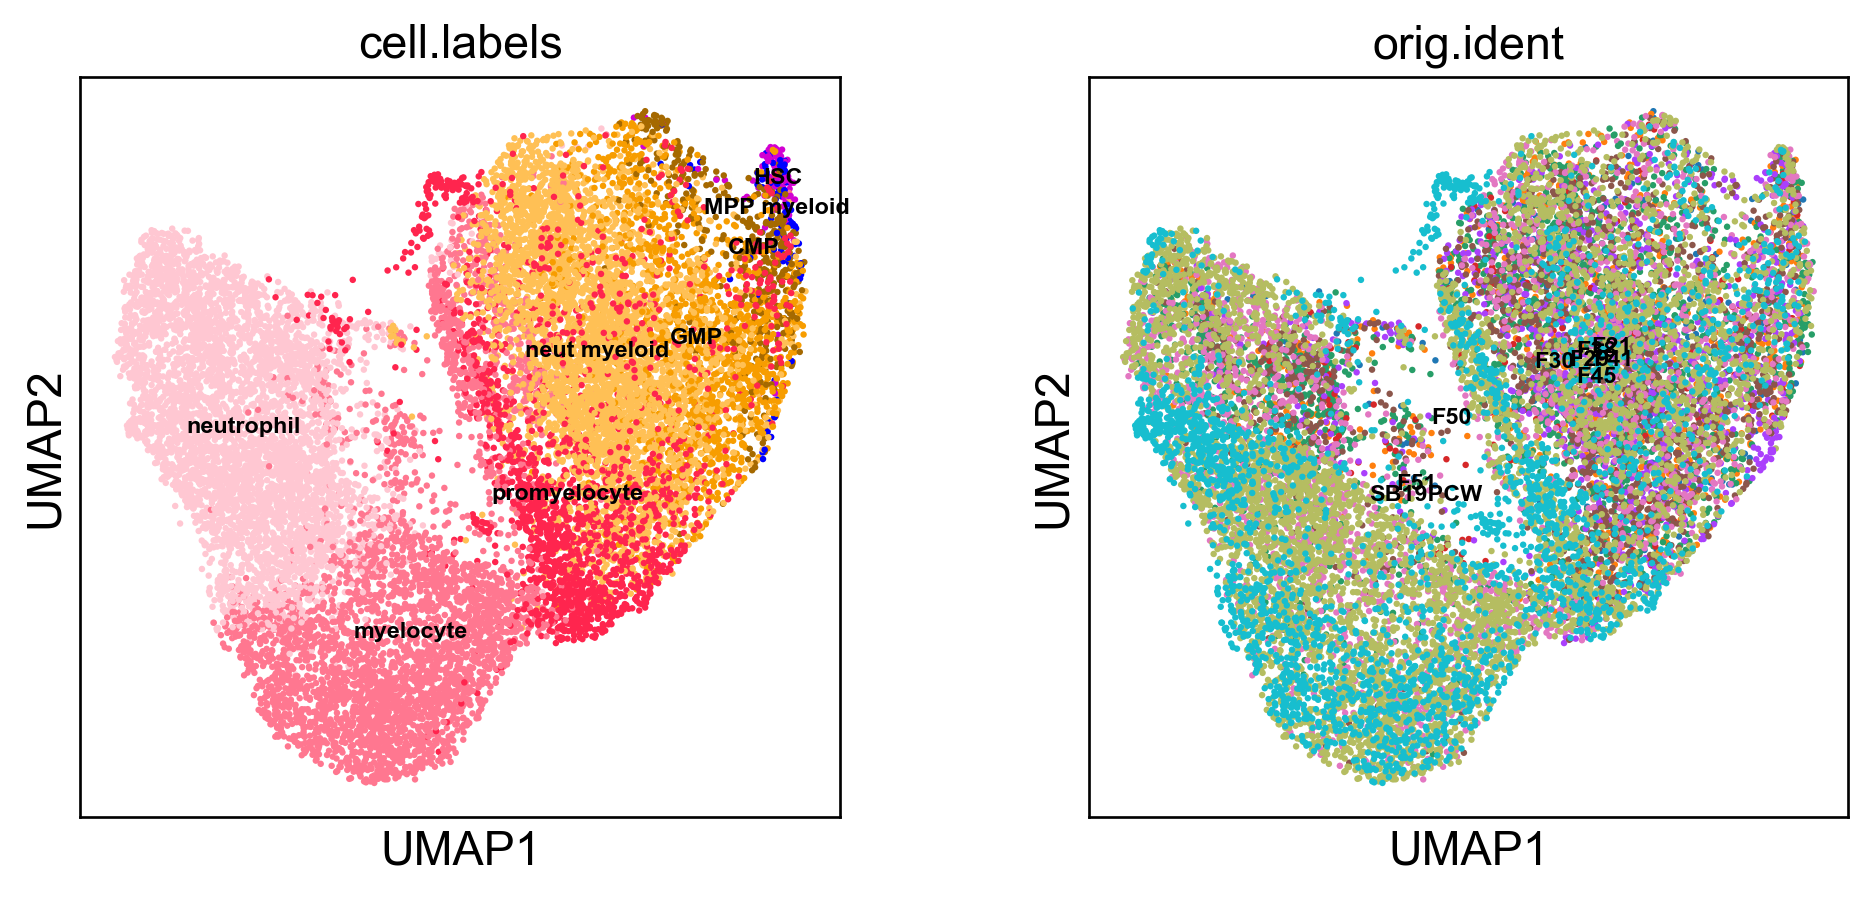

In [34]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15, legend_loc="on data", legend_fontsize=7) 

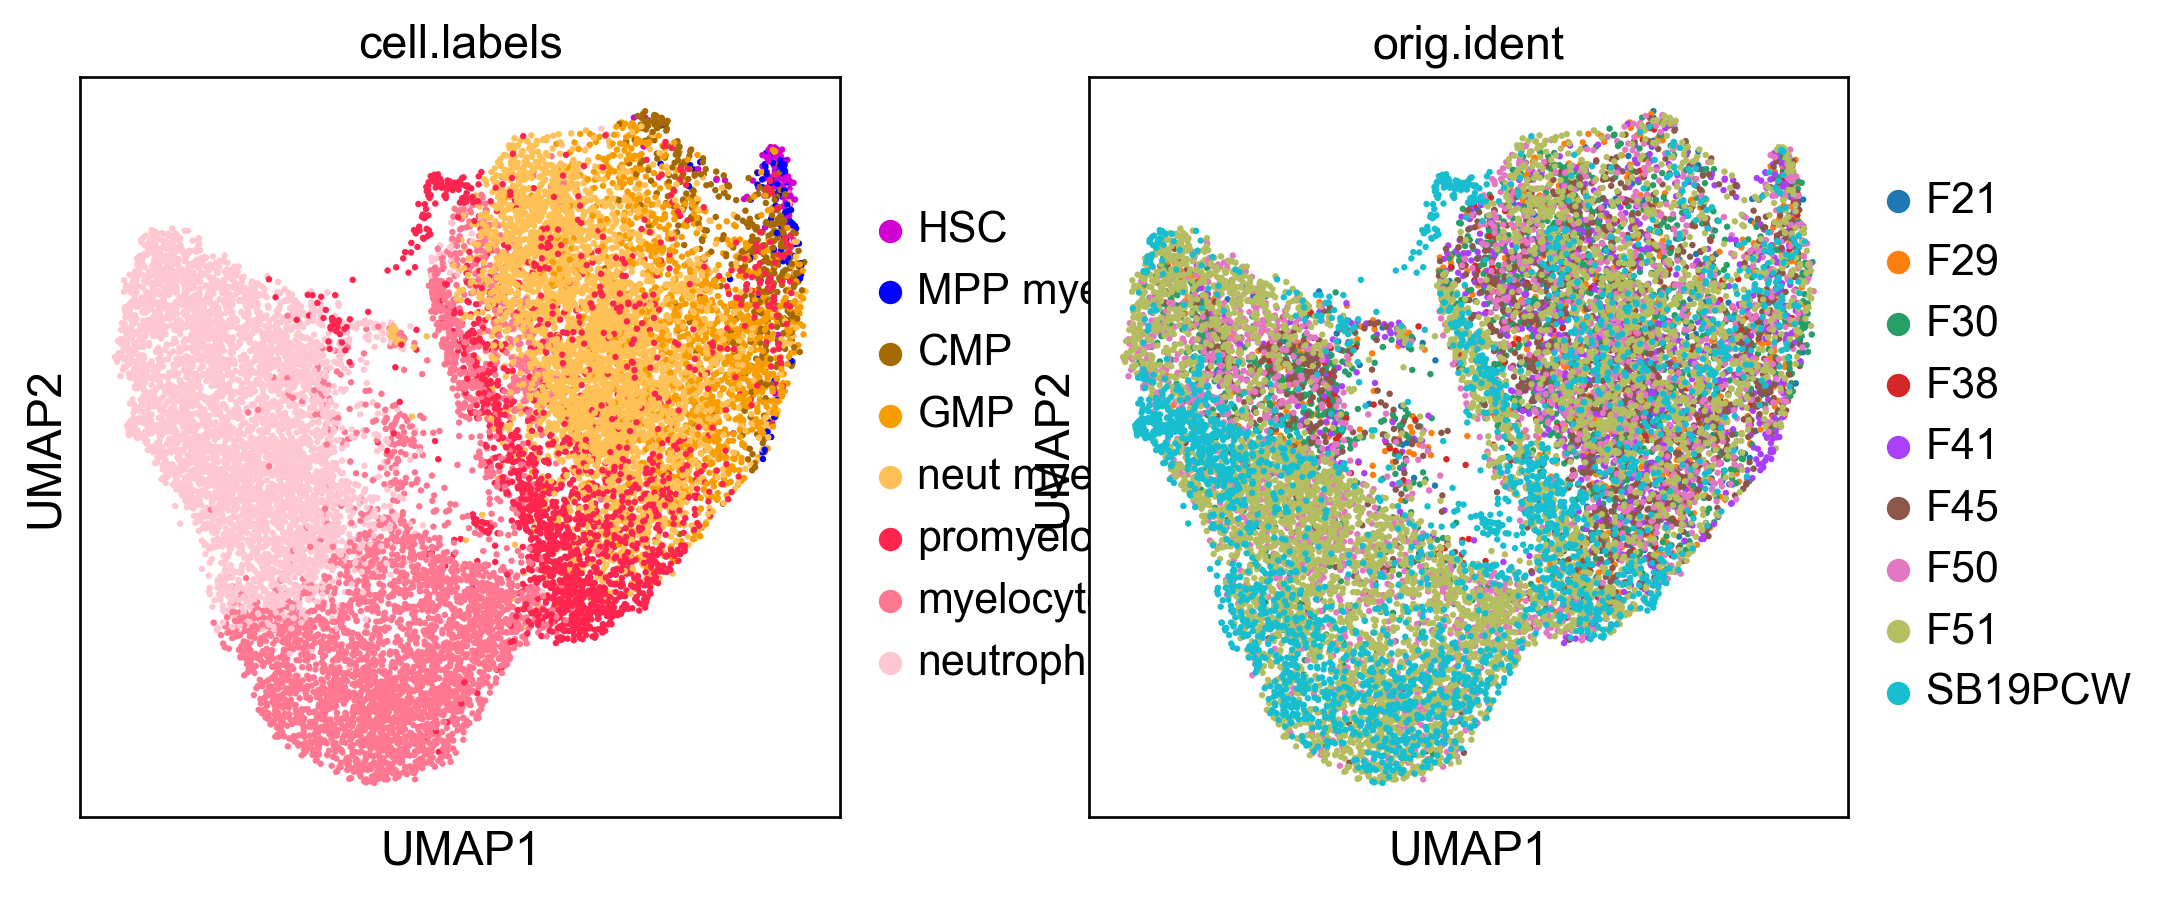

In [35]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

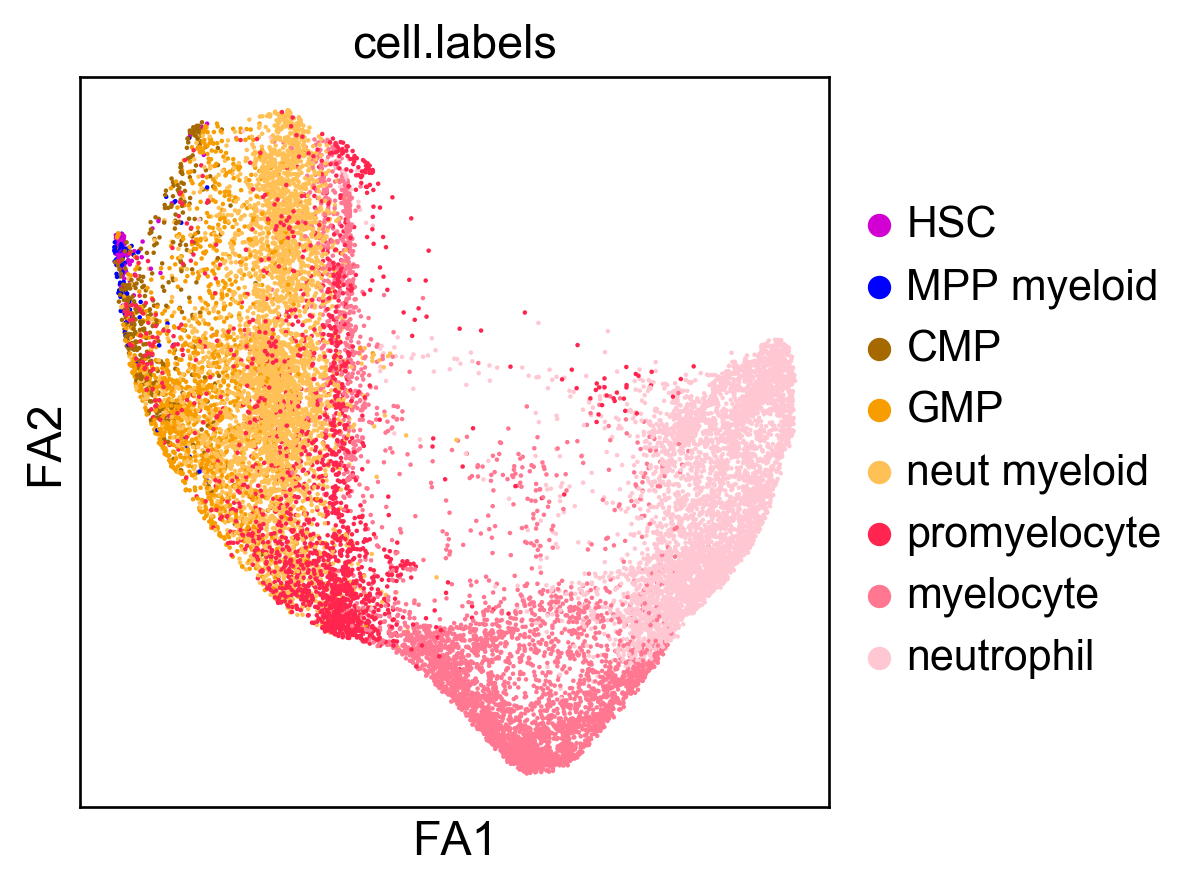

In [36]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa') 

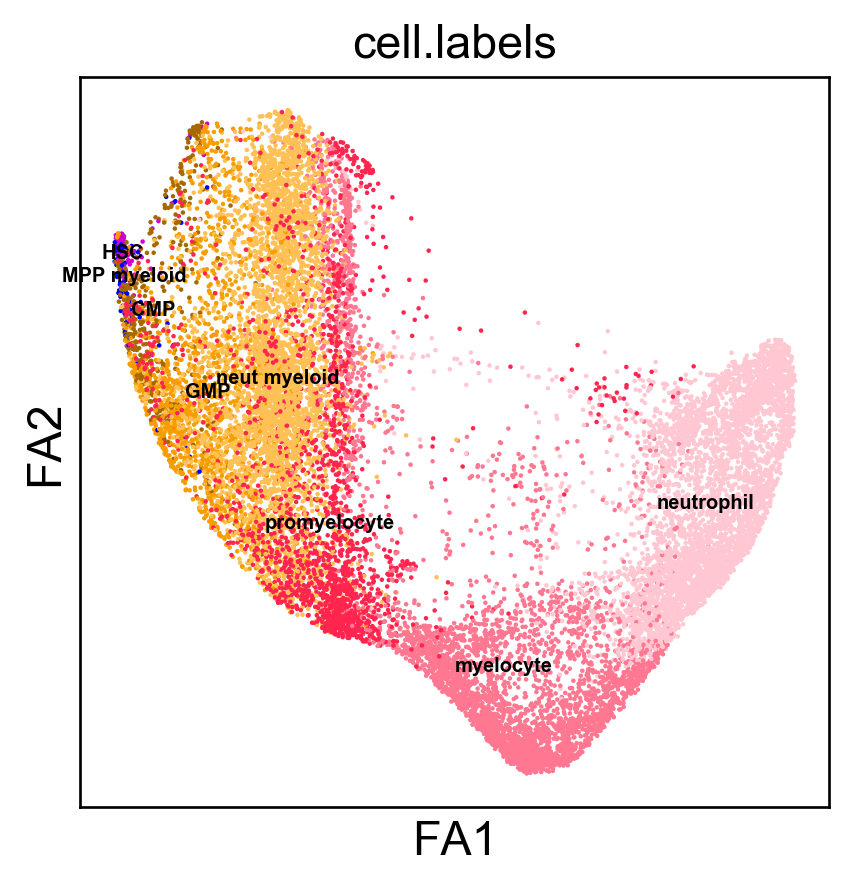

In [37]:
sc.pl.draw_graph(adata, color='cell.labels', legend_loc='on data', legend_fontsize=6) 

# Save plots

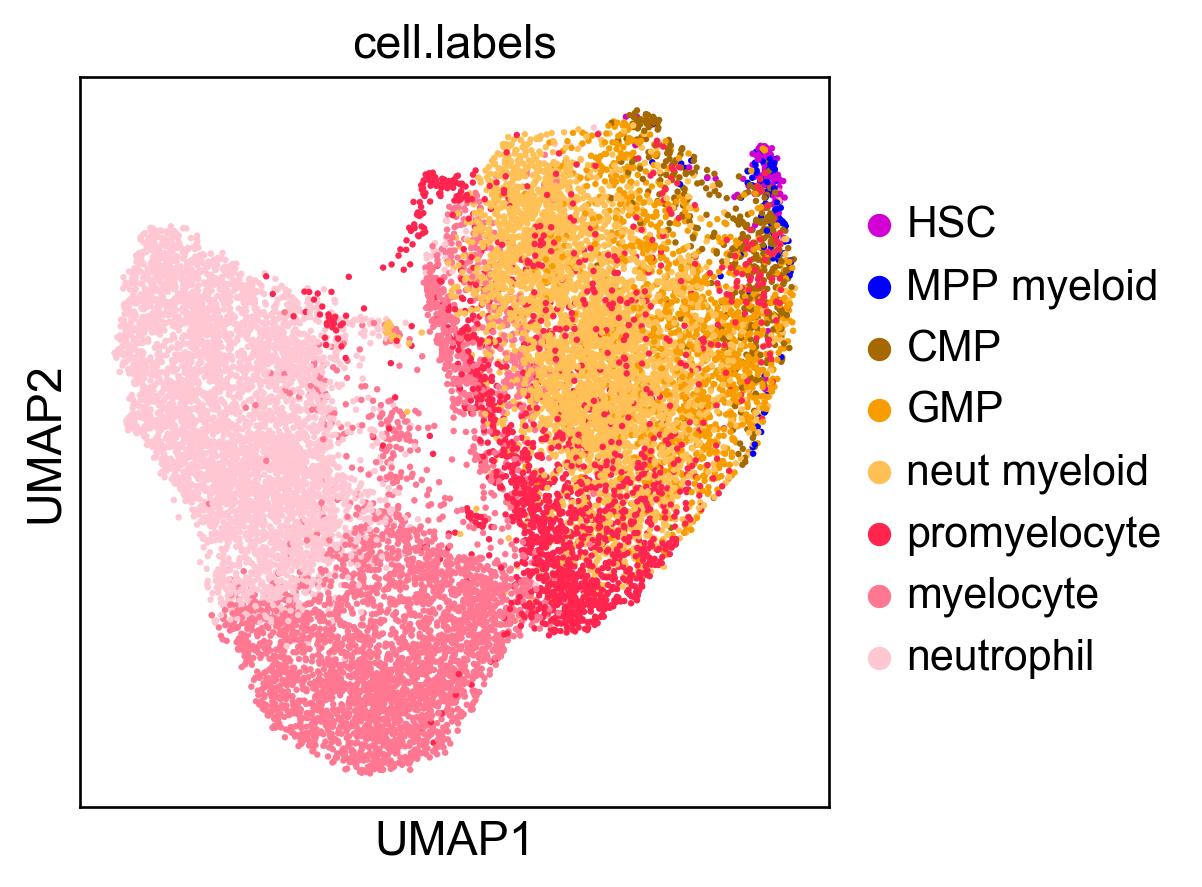

In [38]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=15, save="fig2e_neut_umap_20200615.pdf") 

In [39]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', show=False, save='_fig2e_neut_fdg_20200615.pdf')

# Save the data

In [40]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [41]:
adata.X

<16370x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 26150847 stored elements in Compressed Sparse Row format>

In [42]:
adata.raw.X

<16370x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 28253251 stored elements in Compressed Sparse Row format>

In [43]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2e_neut_dr_20200615.h5ad")